In [1]:
%matplotlib inline
import numpy as np
import scipy.integrate
import scipy.interpolate
import matplotlib.pyplot as plt

import shared_functions_setup as setup
import shared_functions_wlp_wls as shared

SURVEY = 'SDSS'
endfile = 'HODupdate'

if (SURVEY=='SDSS'):
    import params as pa
elif (SURVEY=='LSST_DESI'):
    import params_LSST_DESI as pa
else:
    print "We don't have support for that survey yet; exiting."
    exit()

/usr/local/lib/python2.7/dist-packages/halotools/sim_manager/halo_table_cache.py:12: UserWarning: Some of the functionality of the HaloTableCache classrequires h5py to be installed.
  warn("Some of the functionality of the HaloTableCache class"
/usr/local/lib/python2.7/dist-packages/halotools/sim_manager/user_supplied_ptcl_catalog.py:13: UserWarning: Most of the functionality of the sim_manager sub-package requires h5py to be installed,
which can be accomplished either with pip or conda
  warn("Most of the functionality of the sim_manager "
/usr/local/lib/python2.7/dist-packages/halotools/sim_manager/download_manager.py:39: UserWarning: Some of the functionality of the DownloadManager requires h5py to be installed,
which can be accomplished either with pip or conda
  warn("Some of the functionality of the DownloadManager requires h5py to be installed,\n"
/usr/local/lib/python2.7/dist-packages/halotools/sim_manager/cached_halo_catalog.py:15: UserWarning: Most of the functionality of the

In [2]:
def sigma_e(z_s_):
    """ Returns a value for the model for the per-galaxy noise as a function of source redshift"""

    if hasattr(z_s_, "__len__"):
        sig_e = 2. / pa.S_to_N * np.ones(len(z_s_))
    else:
        sig_e = 2. / pa.S_to_N

    return sig_e

def get_SigmaC_inv(z_s_, z_l_):
    """ Returns the theoretical value of 1/Sigma_c, (Sigma_c = the critcial surface mass density).
    z_s_ and z_l_ can be 1d arrays, so the returned value will in general be a 2d array. """

    com_s = chi_of_z(z_s_) 
    com_l = chi_of_z(z_l_) 

    # Get scale factors for converting between angular-diameter and comoving distances.
    a_l = 1. / (z_l_ + 1.)
    a_s = 1. / (z_s_ + 1.)
    
    D_s = a_s * com_s # Angular diameter source distance.
    D_l = a_l * com_l # Angular diameter lens distance
    
    # The dimensions of D_ls depend on the dimensions of z_s_ and z_l_
    if ((hasattr(z_s_, "__len__")==True) and (hasattr(z_l_, "__len__")==True)):
        D_ls = np.zeros((len(z_s_), len(z_l_)))
        Sigma_c_inv = np.zeros((len(z_s_), len(z_l_)))
        for zsi in range(0,len(z_s_)):
            for zli in range(0,len(z_l_)):
                D_ls[zsi, zli] = D_s[zsi] - D_l[zli]
                # Units are pc^2 / (h Msun), comoving
                if(D_ls[zsi, zli]<0.):
                    Sigma_c_inv[zsi, zli] = 0.
                else:
                    Sigma_c_inv[zsi, zli] = 4. * np.pi * (pa.Gnewt * pa.Msun) * (10**12 / pa.c**2) / pa.mperMpc *   D_l[zli] * D_ls[zsi, zli] * (1 + z_l_[zli])**2 / D_s[zsi]
    else:
        D_ls = (D_s - D_l) 
        # Units are pc^2 / (h Msun), comoving
        if hasattr(z_s_, "__len__"):
            Sigma_c_inv = np.zeros(len(z_s_))
            for zsi in range(0, len(z_s_)):
                if(D_s[zsi]<=D_l):
                    Sigma_c_inv[zsi] = 0.
                else:
                    Sigma_c_inv[zsi] = 4. * np.pi * (pa.Gnewt * pa.Msun) * (10**12 / pa.c**2) / pa.mperMpc *   D_l * D_ls[zsi]* (1 + z_l_)**2 / D_s[zsi]
        elif hasattr(z_l_, "__len__"): 
            Sigma_c_inv = np.zeros(len(z_l_))
            for zli in range(0,len(z_l_)):
                if(D_s<=D_l[zli]):
                    Sigma_c_inv[zli] = 0.
                else:
                    Sigma_c_inv[zli] = 4. * np.pi * (pa.Gnewt * pa.Msun) * (10**12 / pa.c**2) / pa.mperMpc *   D_l[zli] * D_ls[zli]* (1 + z_l_[zli])**2 / D_s
        else:
            if (D_s<D_l):
                Sigma_c_inv=0.
            else:
                 Sigma_c_inv= 4. * np.pi * (pa.Gnewt * pa.Msun) * (10**12 / pa.c**2) / pa.mperMpc *   D_l * D_ls* (1 + z_l_)**2 / D_s
                    
    return Sigma_c_inv


def weights(e_rms, z_, z_l_):

    """ Returns the inverse variance weights as a function of redshift. """
        
    SigC_t_inv = get_SigmaC_inv(z_, z_l_)

    if ((hasattr(z_, "__len__")==True) and (hasattr(z_l_, "__len__")==True)):
        weights = np.zeros((len(z_), len(z_l_)))
        for zsi in range(0,len(z_)):
            for zli in range(0,len(z_l_)):
                weights[zsi, zli] = SigC_t_inv[zsi, zli]**2/(sigma_e(z_)[zsi]**2 + e_rms**2)
    else:
        if (hasattr(z_, "__len__")):
            weights = SigC_t_inv**2/(sigma_e(z_)**2 + e_rms**2 * np.ones(len(z_)))
        else:
            weights = SigC_t_inv**2/(sigma_e(z_)**2 + e_rms**2 )

    return weights

def weights_shapes(e_rms, z_):
    """ Returns the inverse variance weights as a function of redshift for tangential shear (not DS). """
    if (hasattr(z_, "__len__")):
        weights = 1./(sigma_e(z_)**2 + e_rms**2 * np.ones(len(z_)))
    else:
        weights = 1./(sigma_e(z_)**2 + e_rms**2)

    return weights

def get_NofZ_unnormed(dNdzpar, dNdztype, z):
    """ Returns the dNdz of the sources as a function of photometric redshift, as well as the z points at which it is evaluated."""

    if (dNdztype == 'Nakajima'):
        # dNdz takes form like in Nakajima et al. 2011 equation 3
        a = dNdzpar[0]
        zs = dNdzpar[1]

        nofz_ = (z / zs)**(a-1.) * np.exp( -0.5 * (z / zs)**2)
    elif (dNdztype == 'Smail'):
        # dNdz take form like in Smail et al. 1994
        alpha = dNdzpar[0]
        z0 = dNdzpar[1]
        beta = dNdzpar[2]
        nofz_ = z**alpha * np.exp( - (z / z0)**beta)
    else:
        print "dNdz type "+str(dNdztype)+" not yet supported; exiting."
        exit()

    return  nofz_

The goal here is to simplify the boost function (single lens redshift for example) to debug the 1-halo term problem.

In [3]:
# Set up interpolating functions for z(chi) and chi(z)
(z_of_chi, chi_of_z) = setup.z_interpof_com(SURVEY)

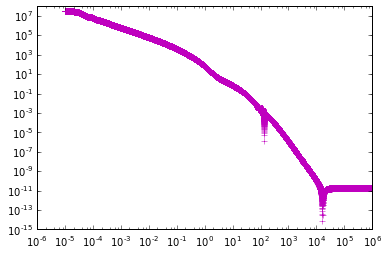

In [4]:
# Import the correlation function, from CLASS w/ halofit + FFTlog. This is for the 2halo term.
# Import also the 1-halo term for the correlation function.
# This is computed using the HOD's of the lens and source samples and FFTlog.
(r, xi_2h_mm) = np.loadtxt('./txtfiles/halofit_xi/xi_2h_zavg_'+SURVEY+'_'+endfile+'.txt', unpack=True)
(r, xi_1h) = np.loadtxt('./txtfiles/xi_1h_terms/xigg_1h_'+SURVEY+'_'+endfile+'.txt', unpack=True)
for ri in range(0,len(r)):
    if r[ri]>3:
        xi_1h[ri] = 0.
xi_2h = pa.bd* pa.bs * xi_2h_mm

xi = xi_1h + xi_2h

plt.figure()
plt.loglog(r, np.abs(xi), 'm+')
#plt.hold(True)
#plt.loglog(r, xi_2h, 'b+')
#plt.hold(True)
#plt.loglog(r, xi_1h, 'g+')
#plt.xlim(0.04, 30)
#plt.ylim(0.001, 10**5)
plt.show()


In [5]:
# Get the comoving distance associated to the lens redshift
chil = setup.com(pa.zeff, SURVEY, pa.cos_par_std)

# Let's take a projection length of 100 Mpc/h
minPiPos = 0.0001
maxPiPos = 200. #chi_of_z(pa.zsmax) - chil
Pi_pos= scipy.logspace(np.log10(minPiPos), np.log10(maxPiPos), 3000)
    
# Pi can be positive or negative, so now flip this and include the negative values, but only down to z=0
# And avoid including multiple of the same values - this messes up some integration routines.
Pi_pos_vec= list(Pi_pos)[1:]
Pi_pos_vec.reverse()
index_cut = next(j[0] for j in enumerate(Pi_pos_vec) if j[1]<=(chil-chi_of_z(pa.zsmin)))
Pi = np.append(-np.asarray(Pi_pos_vec[index_cut:]),np.append([0], Pi_pos))


In [6]:
# Get the correlation function in terms of Pi at a variety of rp values, including rp=1 where we want it for using the power law
rpvec = np.logspace(np.log10(0.05), np.log10(20.), 30)
xi_interp_r= scipy.interpolate.interp1d(r, xi)
xi_ofPi = np.zeros((len(rpvec), len(Pi)))
for ri in range(0,len(rpvec)):
    for pi in range(0,len(Pi)):
        xi_ofPi[ri, pi] = xi_interp_r(np.sqrt(rpvec[ri]**2 + Pi[pi]**2))
        
#plt.figure()
#plt.plot(Pi, np.abs(xi_ofPi[0, :]))
#plt.xlim(-5, 5)
#plt.show()
#print "max=", max(xi_ofPi[0,:])
#ind = next(j[0] for j in enumerate(xi_ofPi[0,:]) if j[1]>2100)
#print "ind Pi=", Pi[ind]
    
# Get the vector of com dist values associated to Pi values:
com_Pi = chil + Pi
z_Pi = z_of_chi(com_Pi)

In [7]:
# Okay, now we do the required integrals:
# Define the z_ph vectors for the three subsamples we care about:
lenzph = 500
z_a = scipy.linspace(pa.zeff, pa.zeff +pa.delta_z, lenzph)
z_b = scipy.linspace(pa.zeff+pa.delta_z, pa.zphmax, lenzph)
# For the "assoc" sample we need to get the z-edges
if (pa.close_cut<chil):
    zasc_min = z_of_chi(chil - pa.close_cut)
    zasc_max = z_of_chi(chil + pa.close_cut)
else:
    zasc_min = 0.
    zasc_max = z_of_chi(chil+ pa.close_cut)
z_asc = scipy.linspace(zasc_min, zasc_max, lenzph)    

# And one for the normalization:
#zp_all = scipy.linspace(pa.zphmin, pa.zphmax, 1000)

#Define a longer one for the z_Pi (spectroscopic source redshift) in the normalization integral
#the correlation is zero far from the lens, but there are still going to be sources which are uncorrelated
# - these should be included in the normalization

z_Pi_norm = scipy.linspace(pa.zsmin, pa.zsmax, 1000)

In [8]:
# Get dNdz of sources
dNdz = get_NofZ_unnormed(pa.dNdzpar_fid, pa.dNdztype, z_Pi)

# And for the normalization
dNdz_norm = get_NofZ_unnormed(pa.dNdzpar_fid, pa.dNdztype, z_Pi_norm)

zpa= 0.283406813627 zpb= 0.541182364729


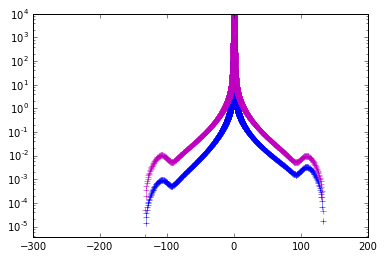

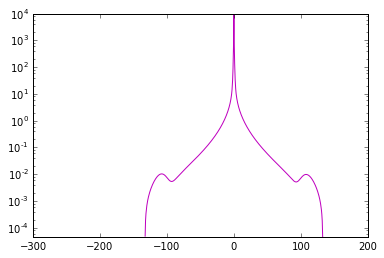

zp= 0.283406813627


In [9]:
i=10
print "zpa=", z_a[i], "zpb=", z_b[i]
pz_b = setup.p_z(z_b[i], z_Pi, pa.pzpar_fid, pa.pztype)
pz_a = setup.p_z(z_a[i], z_Pi, pa.pzpar_fid, pa.pztype)

plt.figure()
plt.semilogy(Pi, pz_b*xi_ofPi[0, :], 'b+')
plt.hold(True)
plt.semilogy(Pi, pz_a*xi_ofPi[0, :], 'm+')
#plt.xlim(-0.1,0.1)
plt.ylim(0,10000)
plt.show()

plt.figure()
plt.semilogy(Pi, pz_a*xi_ofPi[0, :], 'm')
#plt.xlim(0.27,0.29)
plt.ylim(0,10000)
plt.show()

print "zp=", z_a[i]


In [10]:
# Do the integrals in spec-z
specint_num_a = np.zeros((lenzph, len(rpvec))); specint_num_b = np.zeros((lenzph, len(rpvec))); 
specint_num_asc = np.zeros((lenzph, len(rpvec)))
specint_denom_a = np.zeros(lenzph); specint_denom_b = np.zeros(lenzph); 
specint_denom_asc = np.zeros(lenzph)
for i in range(0, lenzph):
    
    pz_a = setup.p_z(z_a[i], z_Pi, pa.pzpar_fid, pa.pztype) 
    pz_b = setup.p_z(z_b[i], z_Pi, pa.pzpar_fid, pa.pztype)
    pz_asc = setup.p_z(z_asc[i], z_Pi, pa.pzpar_fid, pa.pztype)
    
    pz_a_norm = setup.p_z(z_a[i], z_Pi_norm, pa.pzpar_fid, pa.pztype) 
    pz_b_norm = setup.p_z(z_b[i], z_Pi_norm, pa.pzpar_fid, pa.pztype)
    pz_asc_norm = setup.p_z(z_asc[i], z_Pi_norm, pa.pzpar_fid, pa.pztype)
    
    specint_denom_a[i] = scipy.integrate.simps(dNdz_norm * pz_a_norm, z_Pi_norm)
    specint_denom_b[i] = scipy.integrate.simps(dNdz_norm * pz_b_norm, z_Pi_norm)
    specint_denom_asc[i] = scipy.integrate.simps(dNdz_norm * pz_asc_norm, z_Pi_norm)
    
    for ri in range(0, len(rpvec)):  
        specint_num_a[i,ri] = scipy.integrate.simps(dNdz* pz_a* xi_ofPi[ri, :], z_Pi)
        specint_num_b[i,ri] = scipy.integrate.simps(dNdz* pz_b * xi_ofPi[ri, :], z_Pi)
        specint_num_asc[i,ri] = scipy.integrate.simps(dNdz* pz_asc * xi_ofPi[ri, :], z_Pi)
             
#specint_denom = np.zeros(len(zp_all))
#for zi in range(0,len(zp_all)):
#    pz_all = setup.p_z(zp_all[zi], z_Pi, pa.pzpar_fid, pa.pztype)
    
#    specint_denom[zi] = scipy.integrate.simps(dNdz * pz_all, z_Pi)
   
# Now do the integrals in photo-z
w_a = weights(pa.e_rms_Bl_a,z_a, pa.zeff)
w_b= weights(pa.e_rms_Bl_b,z_b, pa.zeff)
w_asc = weights_shapes(pa.e_rms_a,pa.zeff)

#w_all_Bl = weights(pa.e_rms_Bl_a, zp_all, pa.zeff)
#w_all_shapes = weights_shapes(pa.e_rms_a, pa.zeff)

Boost_a = np.zeros(len(rpvec))
Boost_b = np.zeros(len(rpvec))
Boost_asc = np.zeros(len(rpvec))
for ri in range(0,len(rpvec)):
        Boost_a[ri]= scipy.integrate.simps(w_a * specint_num_a[:, ri], z_a) / scipy.integrate.simps(w_a*specint_denom_a, z_a)
        Boost_b[ri] = scipy.integrate.simps(w_b * specint_num_b[:, ri], z_b) / scipy.integrate.simps(w_b*specint_denom_b, z_b)
        Boost_asc[ri] = scipy.integrate.simps(w_asc*specint_num_asc[:, ri], z_asc) / scipy.integrate.simps(w_asc* specint_denom_asc, z_asc)
        #Boost_a[ri]= scipy.integrate.simps(w_a * specint_num_a[:, ri], z_a) / scipy.integrate.simps(w_all_Bl*specint_denom, zp_all)
        #Boost_b[ri] = scipy.integrate.simps(w_b * specint_num_b[:, ri], z_b) / scipy.integrate.simps(w_all_Bl*specint_denom, zp_all)
        #Boost_asc[ri] = scipy.integrate.simps(w_asc*specint_num_asc[:, ri], z_asc) / scipy.integrate.simps(w_all_shapes* specint_denom, zp_all)
        
        
    
Boost_a_interp= scipy.interpolate.interp1d(rpvec, Boost_a)
Boost_b_interp = scipy.interpolate.interp1d(rpvec, Boost_b)
Boost_asc_interp = scipy.interpolate.interp1d(rpvec, Boost_asc)


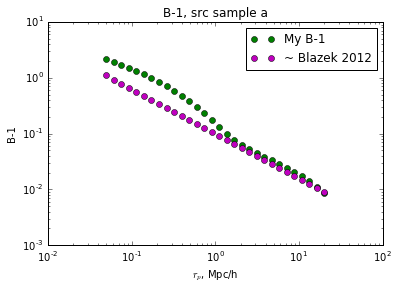

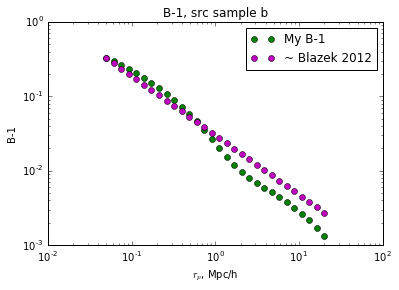

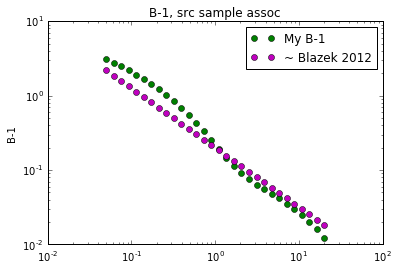

Boost-1, sample a= 0.154894454561
Boost-1, sample b = 0.0238888815588
Boost-1, sample assoc = 0.224490659052


In [11]:
plt.figure()
plt.loglog(rpvec, Boost_a, 'go', label="My B-1")
#plt.hold(True)
#plt.loglog(rpvec, Boost_b, 'bo', label="My B-1 b")
plt.hold(True)
#plt.loglog(rpvec,  Boost_a_interp(1.) * rpvec**(-0.8), 'mo', label="~ Blazek 2012")
plt.loglog(rpvec, 0.1 * rpvec**(-0.8), 'mo', label="~ Blazek 2012")
plt.xlabel("$r_p$, Mpc/h")
plt.ylabel("B-1")
plt.title("B-1, src sample a")
plt.legend()
plt.savefig('./plots/Boost_a_fixsampling_'+str(SURVEY)+'_'+endfile+'.pdf')
#plt.show()

plt.figure()
plt.loglog(rpvec, Boost_b, 'go', label="My B-1")
plt.hold(True)
#plt.loglog(rpvec,  Boost_b_interp(1.) * rpvec**(-0.8), 'mo', label="Power law assumption")
plt.loglog(rpvec,  0.03 * rpvec**(-0.8), 'mo', label="~ Blazek 2012")
plt.xlabel("$r_p$, Mpc/h")
plt.ylabel("B-1")
plt.title("B-1, src sample b")
plt.legend()
plt.savefig('./plots/Boost_b_fixsampling_'+str(SURVEY)+'_'+endfile+'.pdf')
#plt.show()

plt.figure()
plt.loglog(rpvec, Boost_asc, 'go', label="My B-1")
plt.hold(True)
#plt.loglog(rpvec,  Boost_asc_interp(1.) * rpvec**(-0.8), 'mo', label="Power law assumption")
plt.loglog(rpvec,  0.2 * rpvec**(-0.8), 'mo', label="~ Blazek 2012")
plt.ylabel("B-1")
plt.title("B-1, src sample assoc")
plt.legend()
#plt.savefig('./plots/Boost_assoc_fixsampling_'+str(SURVEY)+'_'+endfile+'.pdf')
plt.show()


print "Boost-1, sample a=", Boost_a_interp(1.)
print "Boost-1, sample b =", Boost_b_interp(1.)
print "Boost-1, sample assoc =", Boost_asc_interp(1.)